In [1]:
'''
if you can't find the package in Google Colab, please uncomment the following 
commend and run this cell first!
'''
!pip install yfinance

     |████████████████████████████████| 6.3 MB 42.6 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
## import standard package
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
%matplotlib inline
import time
from datetime import date
import seaborn as sns

## import web scraping package
import requests

## import sklearn package
from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression

### **Step 1: Data cleanning**

In [3]:
## Web Scraping using panda
url = 'https://www.buffett.online/en/portfolio/'
r = requests.get(url)
df_list = pd.read_html(r.text)                                                  # this parses all the tables in webpages to a list
df = df_list[0]                                                                 # this is a very important step, it converts list to pd dataframe

## data cleaning
df.dropna(inplace=True)
df.columns = df.iloc[0]
df_clean = df.drop(index=0)

## store tickers and % of total portfolio into numpy array for future 
tickers = np.array(df_clean['Ticker'])
weights = np.array(df_clean['% of total portfolio'])
tickers = ' '.join(tickers).split(' ')
weights = ' '.join(weights).split("%")
weights = weights

In [4]:
## import data from yahoo finance
## date range from user defined start date to today
start_date = "2015-01-02"                                                       # if we want to start 2015, we need to start on 2015-01-02, otherwise it will create extra data from 2014-12-31
today = date.today()

buffett_portfolio = yf.download(tickers, start=start_date, end=today)['Adj Close']
buffett_portfolio["Date"] = buffett_portfolio.index
buffett_portfolio.reset_index(drop=True,inplace=True)
print(buffett_portfolio)

[*********************100%***********************]  42 of 42 completed
            AAPL        ABBV         AMZN         AON         AXP        BAC  \
0      24.745996   48.810200   308.519989   87.442413   83.556068  15.724234   
1      24.048866   47.891632   302.190002   86.598862   81.346359  15.267433   
2      24.051128   47.654591   295.290009   86.079750   79.612717  14.810643   
3      24.388378   49.580612   298.420013   87.062370   81.351456  14.880919   
4      25.325426   50.099163   300.459991   88.341583   82.504623  15.188378   
...          ...         ...          ...         ...         ...        ...   
1739  160.240005  116.889999  3561.570068  296.690002  157.860001  45.371616   
1740  165.300003  115.279999  3507.070068  295.769989  152.300003  44.256985   
1741  164.770004  115.910004  3443.719971  291.109985  150.059998  43.630001   
1742  163.759995  116.870003  3437.360107  297.299988  156.770004  44.889999   
1743  161.839996  118.849998  3389.790039  292.89

weights of stocks less than 5 years: 1.9099999999999997%
{'AAPL': '42.78', 'BAC': ' 14.61', 'AXP': ' 8.66', 'KO': ' 7.15', 'MCO': ' 2.99', 'VZ': ' 2.92', 'USB': ' 2.56', 'DVA': ' 1.43', 'BK': ' 1.28', 'GM': ' 1.08', 'CHTR': ' 1.04', 'CVX': ' 0.99', 'VRSN': ' 0.90', 'KR': ' 0.85', 'V': ' 0.73', 'AMZN': ' 0.60', 'ABBV': ' 0.53', 'MA': ' 0.51', 'BMY': ' 0.44', 'AON': ' 0.43', 'RH': ' 0.41', 'STOR': ' 0.27', 'TMUS': ' 0.23', 'GL': ' 0.19', 'MMC': ' 0.14', 'TEVA': ' 0.14', 'SIRI': ' 0.09', 'JNJ': ' 0.02', 'PG': ' 0.02', 'MDLZ': ' 0.01', 'SPY': ' 0.01', 'VOO': ' 0.01', 'WFC': ' 0.01', 'UPS': ' 0.00'}
            AAPL        ABBV         AMZN         AON         AXP        BAC  \
0      24.745996   48.810200   308.519989   87.442413   83.556068  15.724234   
1      24.048866   47.891632   302.190002   86.598862   81.346359  15.267433   
2      24.051128   47.654591   295.290009   86.079750   79.612717  14.810643   
3      24.388378   49.580612   298.420013   87.062370   81.351456  14.880919  

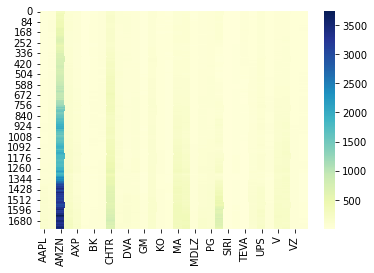

In [5]:
## Data cleanning, drop stocks with NA values
stock_less_than_5yrs = buffett_portfolio.columns[buffett_portfolio.isnull().any()] #pull out all the stocks with listed date less than 5 yrs

##We noticed there are only 34 stock that lasts for five+ years. 
##Calculate weights for those new stocks, we can find out if we can really drop those stocks or not?
stock_with_weights = zip(tickers, weights)
stock_port_dict = dict(stock_with_weights)# store the stocks and weights into a dictionary
#print(stock_port_dict)
stock_less_than_5yrs = np.array(stock_less_than_5yrs)

stock_less_than_5yrs_weights = 0.0
for key in stock_less_than_5yrs:
  stock_less_than_5yrs_weights = stock_less_than_5yrs_weights + float(stock_port_dict.get(key))
  stock_port_dict.pop(key)
print("weights of stocks less than 5 years: " + str(stock_less_than_5yrs_weights) + "%") 
## number is 1.9%, which means it is small enough so that we can dropped those stocks
print(stock_port_dict)
#stock_port_dict_new = pd.DataFrame.from_dict(stock_port_dict,orient='index')

#drop the stocks with listed date less than 5 years
buffett_portfolio_new = buffett_portfolio.dropna(axis=1)
#drop two ETF in the portfolio
buffett_portfolio_new = buffett_portfolio_new.drop(columns = ['VOO','SPY'])
tickers_new = buffett_portfolio_new.iloc[:,:-1].columns
buffett_portfolio_new.head()
print(buffett_portfolio_new)
sns.heatmap(buffett_portfolio_new.iloc[:,:-1],cmap="YlGnBu")

### **Step 2: PCA analysis**

[0.74741292 0.86256541 0.91983578 0.94091785 0.95604866]


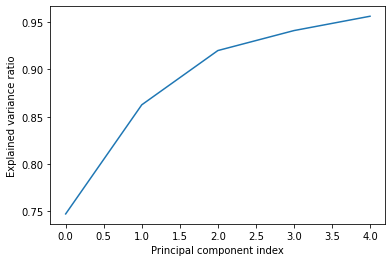

          0         1         2         3         4
0 -5.959001 -0.898106 -0.781684 -0.622669 -0.526979
1 -6.164028 -0.983905 -0.588320 -0.659942 -0.637252
2 -6.258005 -1.031851 -0.483910 -0.689649 -0.632236
3 -6.086370 -1.123452 -0.631053 -0.716616 -0.539695
4 -5.875686 -1.155978 -0.731484 -0.640248 -0.370913
(1744, 5)


In [16]:
## set up PCA pipeline
X = buffett_portfolio_new.iloc[:,:-1]                                           # set the dataset with complete 
num_comp = 5
pipe = Pipeline([('scaler', StandardScaler()),
                 ('reducer', PCA(n_components=num_comp))])
#Fit training data into PCA to get principle components
pc = pipe.fit_transform(X.iloc[:,:-1])
var = pipe.steps[1][1].explained_variance_ratio_.cumsum()
print(var)

##Plotting the reverse elbow graph to show how many PC we need
plt.plot(var)
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')
plt.show()

pc_df = pd.DataFrame(pc)
print(pc_df.head())
print(pc_df.shape)

In [7]:
## Set up linear regression
lr = LinearRegression()
lr.fit(X, pc)
##Get all the betas
lr_array = np.array(lr.coef_)
print(pd.DataFrame(lr_array).T)
##Setup benchmark to be the mean of all coefficient
benchmark = lr_array.mean()

##Create a dictionary with princple component and regression results
pc_lst = [i+1 for i in range(num_comp)]
stocks_regression_dict = dict(zip(pc_lst, lr_array))

##Convert the dictionary to dataframe for easier calculation
stocks_regression_dict = pd.DataFrame(stocks_regression_dict, index=tickers_new)
# print(stocks_regression_dict[1].mean())
# print(stocks_regression_dict[2].mean())
# print(stocks_regression_dict[3].mean())
# print(stocks_regression_dict[1]>stocks_regression_dict[1].mean())
# print(stocks_regression_dict[2]>stocks_regression_dict[2].mean())
# print(stocks_regression_dict[3]>stocks_regression_dict[3].mean())

stocks_regression_dict_ = []
for index in stocks_regression_dict:
  stocks_regression_dict_.append(stocks_regression_dict[index] > stocks_regression_dict[index].mean())

stocks_regression_dict_ = pd.DataFrame(stocks_regression_dict_)
stocks_regression_dict_T = stocks_regression_dict_.T
stocks_regression_dict_T = stocks_regression_dict_T.replace(False, np.NaN)
print(stocks_regression_dict_T)

#Stock Selecting method 1, we choose stocks with all three PCs > Benchmark
portfolio1 = stocks_regression_dict_T.dropna(thresh=3)
ticker_1 = np.array(portfolio1.index)
ticker_1 = ' '.join(ticker_1).split(' ')
print(ticker_1)

##Stock Selecting method 2, we choose stocks with at least one three PCs > Benchmark
portfolio2 = stocks_regression_dict_T.dropna(thresh=2)
ticker_2 = np.array(portfolio2.index)
ticker_2 = ' '.join(ticker_2).split(' ')
print(ticker_2)

##Stock Selecting method 2, we choose stocks with at least one three PCs > Benchmark
portfolio3 = stocks_regression_dict_T.dropna(thresh=1)
ticker_3 = np.array(portfolio3.index)
ticker_3 = ' '.join(ticker_3).split(' ')
print(ticker_3)

               0             1             2
0   4.935528e-03 -4.239545e-03 -9.722021e-05
1   8.847751e-03 -2.936533e-05 -4.317820e-03
2   1.989080e-04 -7.142921e-05  1.151854e-04
3   3.630820e-03 -6.536198e-05  7.406468e-04
4   6.386443e-03  1.416010e-03 -4.057505e-03
5   2.278002e-02  1.425462e-02 -2.085553e-02
6   1.806374e-02  4.209312e-02 -6.329218e-02
7   1.450427e-02 -5.057733e-02 -2.781143e-02
8   1.166685e-03 -4.862191e-04  4.034107e-04
9   8.443510e-03  2.687272e-02 -1.264274e-02
10  7.124468e-03 -1.762129e-02 -1.191567e-02
11  1.166552e-02  1.325737e-02 -4.723158e-05
12  1.778720e-02  2.751264e-03 -3.690147e-02
13  8.073529e-03  8.667157e-04  2.240993e-03
14  2.840590e-02  4.395183e-03  1.533263e-02
15  1.109162e-02 -7.895484e-02 -3.379356e-02
16  1.998638e-03 -1.627996e-04  1.642743e-03
17  2.313947e-03 -9.928046e-04  5.350888e-04
18  2.224658e-02 -1.020441e-02  1.489648e-02
19  6.963694e-03 -8.630030e-04  2.705829e-04
20  7.338877e-03 -3.478205e-03  6.808571e-03
21  9.6960

### **Step 3 Efficient Frontier with our portfolio**

In [8]:
## our frontier, 
frontier1 = yf.download(ticker_1, start=start_date, end=today)['Adj Close']
frontier2 = yf.download(ticker_2, start=start_date, end=today)['Adj Close']
frontier3 = yf.download(ticker_3, start=start_date, end=today)['Adj Close']

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  9 of 9 completed
[*********************100%***********************]  27 of 27 completed


In [9]:
def create_frontier(portfolio, num_portfolios):
  """Create Efficient market frontier using randomly genrated portfolio

  Parameters:
  portfolio      (pd.Dataframe): stock data from yahoo imported using yfinance
  num_portfolios (int)         : user defined of how many random generated portfolio needed 
  
  Returns:
  portfolios                   : Returning the num_portfolios portfolios created in pd.Dataframe

  """
  p_ret = []                                                                    # Define an empty array for portfolio returns
  p_vol = []                                                                    # Define an empty array for portfolio volatility
  p_weights = []                                                                # Define an empty array for asset weights
  num_assets = len(portfolio.columns)
  cov_matrix = portfolio.pct_change().apply(lambda x: np.log(1+x)).cov()
  ind_er = portfolio.resample('Y').last().pct_change().mean()                   # Yearly returns for individual companies
  
  for port in range(num_portfolios):
      weights = np.random.random(num_assets)
      weights = weights/np.sum(weights)
      p_weights.append(weights)
      returns = np.dot(weights, ind_er)                                         # Returns are the product of individual expected returns of asset and its weights
      p_ret.append(returns)
      var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()    # Portfolio Variance
      sd = np.sqrt(var)                                                         # Daily standard deviation
      ann_sd = sd*np.sqrt(252)                                                  # Annual standard deviation = volatility
      p_vol.append(ann_sd)

  data = {'Returns':p_ret, 'Volatility':p_vol}

  for counter, symbol in enumerate(portfolio.columns.tolist()):
      #print(counter, symbol)
      data[symbol] = [w[counter] for w in p_weights]

  portfolios  = pd.DataFrame(data)
  
  return portfolios                                                           

In [10]:
## created two efficient frontier 
portfolio1 = create_frontier(frontier1, 20000)
portfolio2 = create_frontier(frontier2, 20000)
portfolio3 = create_frontier(frontier3, 20000)

In [18]:
print(portfolio2)
# Plot efficient frontier
## investigate
min_vol_port_1 = round(portfolio1.iloc[portfolio1['Volatility'].idxmin()],5)     # idxmin() gives us the minimum value in the column specified.      
min_vol_port_2 = round(portfolio2.iloc[portfolio2['Volatility'].idxmin()],4)      # idxmin() gives us the minimum value in the column specified.      
min_vol_port_3 = round(portfolio3.iloc[portfolio3['Volatility'].idxmin()],12)      # idxmin() gives us the minimum value in the column specified.      

##Grouping the min_vol_port data to a dictionary
new_port_1 = pd.DataFrame(min_vol_port_1)  
new_port_dict_1 = dict(zip(new_port_1.index, min_vol_port_1))
[new_port_dict_1.pop(key) for key in ['Returns','Volatility']]
print(sum([new_port_dict_1.get(key) for key in new_port_dict_1]))

new_port_2 = pd.DataFrame(min_vol_port_2)  
new_port_dict_2 = dict(zip(new_port_2.index, min_vol_port_2))
[new_port_dict_2.pop(key) for key in ['Returns','Volatility']]
print(sum([new_port_dict_2.get(key) for key in new_port_dict_2]))

new_port_3 = pd.DataFrame(min_vol_port_3)  
new_port_dict_3 = dict(zip(new_port_3.index, min_vol_port_3))
[new_port_dict_3.pop(key) for key in ['Returns','Volatility']]
print(sum([new_port_dict_3.get(key) for key in new_port_dict_3]))

        Returns  Volatility       BAC        BK        GL        KO      MDLZ  \
0      0.099694    0.190085  0.082959  0.093391  0.126401  0.150476  0.155785   
1      0.106011    0.215513  0.096363  0.205942  0.071995  0.085333  0.033568   
2      0.110231    0.214886  0.106963  0.023875  0.176462  0.086821  0.065575   
3      0.102262    0.189634  0.098859  0.112502  0.094317  0.220132  0.056842   
4      0.101164    0.202684  0.078104  0.170145  0.124976  0.059738  0.145624   
...         ...         ...       ...       ...       ...       ...       ...   
19995  0.090623    0.192464  0.014753  0.103955  0.061999  0.093559  0.333606   
19996  0.108789    0.213068  0.123645  0.102296  0.280944  0.014499  0.081301   
19997  0.100625    0.187802  0.131147  0.171268  0.058105  0.191400  0.113356   
19998  0.116155    0.208347  0.189662  0.189718  0.051143  0.126986  0.012671   
19999  0.097571    0.191046  0.081308  0.065234  0.072461  0.058892  0.109610   

           SIRI      STOR  

<Figure size 432x288 with 0 Axes>

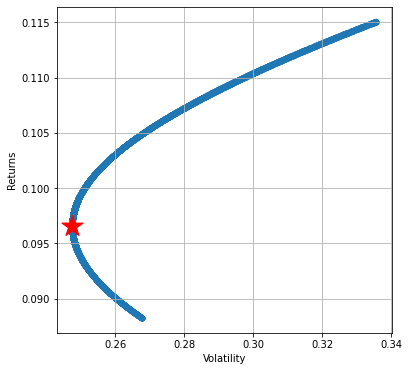

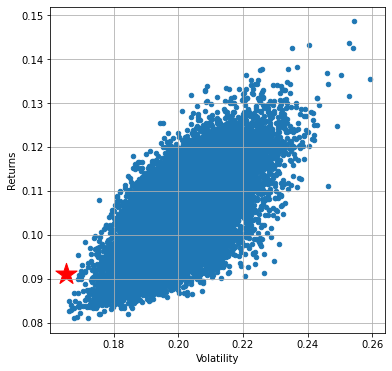

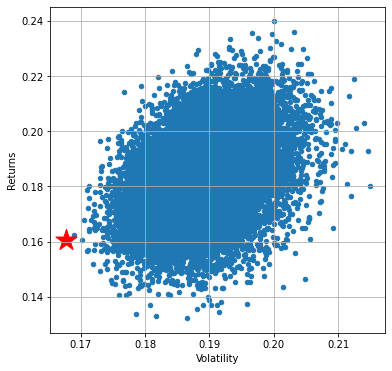

In [12]:
## plotting the minimum volatility portfolio
plt.figure(1)
portfolio1.plot.scatter(x='Volatility', y='Returns', marker='o', grid=True, figsize=[6,6])
plt.scatter(min_vol_port_1[1], min_vol_port_1[0], color='r', marker='*', s=500)

plt.figure(2)
portfolio2.plot.scatter(x='Volatility', y='Returns', marker='o', grid=True, figsize=[6,6])
plt.scatter(min_vol_port_2[1], min_vol_port_2[0], color='r', marker='*', s=500)

plt.figure(2)
portfolio3.plot.scatter(x='Volatility', y='Returns', marker='o', grid=True, figsize=[6,6])
plt.scatter(min_vol_port_3[1], min_vol_port_3[0], color='r', marker='*', s=500)

### **Step 4 Use the weights to backtest our results**

<Figure size 432x288 with 0 Axes>

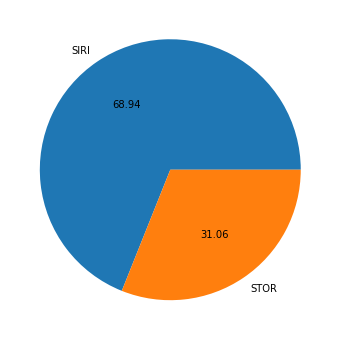

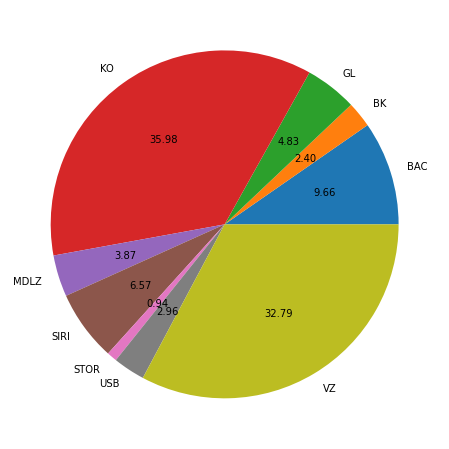

<Figure size 432x288 with 0 Axes>

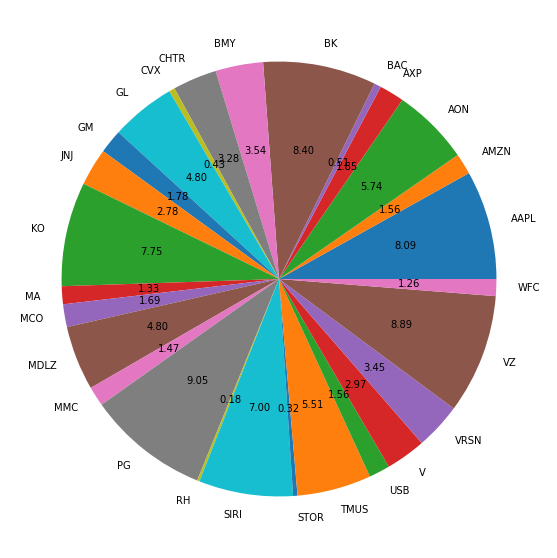

In [13]:
##Portfolio Asset Allocation. 
##Shown in pie chart
allocation_pct_1 = np.array(min_vol_port_1[2:])
final_tickers_1 = new_port_1.index[2:]

allocation_pct_2 = np.array(min_vol_port_2[2:])
final_tickers_2 = new_port_2.index[2:]

allocation_pct_3 = np.array(min_vol_port_3[2:])
final_tickers_3 = new_port_3.index[2:]

plt.figure(1)
plt.subplots(figsize=[6,6])
plt.pie(allocation_pct_1, labels = final_tickers_1,autopct='%.2f')

plt.figure(2)
plt.subplots(figsize=[8,8])
plt.pie(allocation_pct_2, labels = final_tickers_2,autopct='%.2f')
plt.show()  

plt.figure(3)
plt.subplots(figsize=[10,10])
plt.pie(allocation_pct_3, labels = final_tickers_3,autopct='%.2f')
plt.show()  

In [14]:
!pip install portfolio-backtest
!pip install PyPortfolioOpt

     |████████████████████████████████| 61 kB 8.3 MB/s 
     |████████████████████████████████| 2.8 MB 35.7 MB/s 
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.0.31
    Uninstalling cvxpy-1.0.31:
      Successfully uninstalled cvxpy-1.0.31


In [15]:
from portfolio_backtest import Backtest
import pprint

for k, v in stock_port_dict.items():
    stock_port_dict[k] = float(v)

print(stock_port_dict)
buffeet_new_total_weights = sum([stock_port_dict.get(key) for key in stock_port_dict])
print(buffeet_new_total_weights)
stock_port_dict = {k: v / buffeet_new_total_weights for k, v in stock_port_dict.items()}
print(stock_port_dict)
#Backtest(tickers=["VTI", "AGG", "GLD"]).run()
bt = Backtest(
    tickers= stock_port_dict,
    start=start_date,
    end=today
)

bt1 = Backtest(
    tickers= new_port_dict_1,
    start=start_date,
    end=today
)

bt2 = Backtest(
    tickers= new_port_dict_2,
    start=start_date,
    end=today
)

bt3 = Backtest(
    tickers= new_port_dict_3,
    start=start_date,
    end=today
)

print(bt1.discrete_allocation(total_portfolio_value=10000))
print(bt2.discrete_allocation(total_portfolio_value=10000))
print(bt3.discrete_allocation(total_portfolio_value=10000))

pprint.pprint(bt.run(plot=False)[0])
pprint.pprint(bt1.run(plot=False)[0])
pprint.pprint(bt2.run(plot=False)[0])
pprint.pprint(bt3.run(plot=False)[0])

{'AAPL': 42.78, 'BAC': 14.61, 'AXP': 8.66, 'KO': 7.15, 'MCO': 2.99, 'VZ': 2.92, 'USB': 2.56, 'DVA': 1.43, 'BK': 1.28, 'GM': 1.08, 'CHTR': 1.04, 'CVX': 0.99, 'VRSN': 0.9, 'KR': 0.85, 'V': 0.73, 'AMZN': 0.6, 'ABBV': 0.53, 'MA': 0.51, 'BMY': 0.44, 'AON': 0.43, 'RH': 0.41, 'STOR': 0.27, 'TMUS': 0.23, 'GL': 0.19, 'MMC': 0.14, 'TEVA': 0.14, 'SIRI': 0.09, 'JNJ': 0.02, 'PG': 0.02, 'MDLZ': 0.01, 'SPY': 0.01, 'VOO': 0.01, 'WFC': 0.01, 'UPS': 0.0}
94.03000000000003
{'AAPL': 0.4549611826012973, 'BAC': 0.15537594384770811, 'AXP': 0.09209826651068805, 'KO': 0.07603956184196531, 'MCO': 0.03179836222482186, 'VZ': 0.031053918962033383, 'USB': 0.027225353610549816, 'DVA': 0.015207912368393061, 'BK': 0.013612676805274908, 'GM': 0.011485696054450704, 'CHTR': 0.011060299904285862, 'CVX': 0.010528554716579812, 'VRSN': 0.00957141337870892, 'KR': 0.009039668191002869, 'V': 0.007763479740508346, 'AMZN': 0.006380942252472613, 'ABBV': 0.005636498989684142, 'MA': 0.005423800914601721, 'BMY': 0.0046793576518132495

Exception: ignored